In [4]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import umap

In [2]:
data = pd.read_csv('../data/data.csv')

data = data[data['gene_type'] == 'protein_coding']
data = data.T 
data = data.drop(data.index[:3])
data

,0,1,2,3,4,5,6,7,8,9,...,57781,57782,57783,57786,57787,57788,57789,57790,57791,57792
BC01_Pooled,2.33,0.0,60.7,47.93,4.79,0.0,0.06,46.54,11.61,9.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BC01_Tumor,1.25,0.0,28.44,4.43,1.67,0.0,9.64,20.97,5.97,4.81,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BC02_Pooled,43.96,0.0,74.73,9.89,10.87,0.52,0.0,46.3,8.72,19.39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BC03_Pooled,7.64,0.0,41.41,7.61,0.92,0.0,0.0,8.57,5.51,0.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BC03LN_Pooled,9.32,0.0,87.69,7.32,15.13,1.39,0.0,5.72,10.0,27.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC11_69,0.0,0.0,0.0,0.27,0.14,0.0,0.0,7.06,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BC11_70,0.0,0.0,0.0,0.0,247.69,0.0,0.81,4.49,0.0,53.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BC11_78,0.0,0.0,136.07,0.07,22.6,0.0,0.83,0.82,70.26,0.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BC11_81,200.82,0.0,22.03,0.19,11.35,0.0,0.0,4.32,1.12,6.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:

def pca(data):
    '''PCA'''
    # Select only the expression data columns for PCA
    expression_data = data

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(expression_data)

    # Apply PCA
    pca = PCA(n_components=2)  # You can change the number of components as needed
    principal_components = pca.fit_transform(scaled_data)

def tsne(data):
    selected_columns = data
    tsne = TSNE(n_components=2, perplexity=30)  # Adjust parameters as needed

    # Perform t-SNE
    tsne_result = tsne.fit_transform(selected_columns)

def Umap(data):
    selected_columns = data  
    umap_reducer = umap.UMAP(n_components=2)  

    umap_result = umap_reducer.fit_transform(selected_columns)

def ica(data):
    gene_expression = data
    ica = FastICA(n_components=2, random_state=42)


    ica.fit(gene_expression)

    independent_components = ica.transform(gene_expression)

def vae(data):
    expression_data = data.values


    expression_data = (expression_data - np.min(expression_data)) / (np.max(expression_data) - np.min(expression_data))
    expression_data = tf.convert_to_tensor(expression_data, dtype=tf.float32)
    latent_dim = 2 

    encoder_inputs = keras.Input(shape=(expression_data.shape[1],))
    x = keras.layers.Dense(256, activation='relu')(encoder_inputs)
    x = keras.layers.Dense(128, activation='relu')(x)
    z_mean = keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = keras.layers.Dense(latent_dim, name='z_log_var')(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    decoder_inputs = keras.layers.Dense(128, activation='relu')(z)
    decoder_outputs = keras.layers.Dense(expression_data.shape[1], activation='sigmoid')(decoder_inputs)

    vae = keras.Model(encoder_inputs, decoder_outputs)

    reconstruction_loss = tf.keras.losses.mean_squared_error(encoder_inputs, decoder_outputs)
    reconstruction_loss *= expression_data.shape[1]
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    vae.fit(expression_data, epochs=50, batch_size=32)

    encoder = keras.Model(encoder_inputs, z_mean)
    encoded_data = encoder.predict(expression_data)


def find_time(model,execution_times,size):
    # Measure execution time for the algorithm with the current input size
    sample = data.sample(n=size)
    start_time = time.time()
    if model == 'umap':
        Umap(sample)
    elif model == 'pca':
        pca(sample)
    elif model == 'tsne':
        tsne(sample)  # Call your algorithm with the generated data
    elif model == 'ica':
        ica(sample)
    elif model == 'vae':
        vae(sample)
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Store execution time and corresponding dataset size
    execution_times.append(execution_time)

# Define the range of dataset sizes to test
data_sizes = [100,200,300,400,500]  # Example sizes, adjust as needed

# Lists to store computation times and corresponding dataset sizes
pca_execution_times = []
tsne_execution_times = []
umap_execution_times = []
vae_execution_times = []
ica_execution_times = []
input_sizes = []

for size in data_sizes:
    find_time('vae',vae_execution_times,size)
    find_time('ica',ica_execution_times,size)
    find_time('pca',pca_execution_times,size)
    find_time('tsne',tsne_execution_times,size)
    find_time('umap',umap_execution_times,size)
    input_sizes.append(size)




Epoch 1/50
4/4 [==============================] - 2s 78ms/step - loss: 5006.1484
Epoch 2/50
4/4 [==============================] - 0s 81ms/step - loss: 4797.6104
Epoch 3/50
4/4 [==============================] - 0s 79ms/step - loss: 4562.1465
Epoch 4/50
4/4 [==============================] - 0s 80ms/step - loss: 4323.9629
Epoch 5/50
4/4 [==============================] - 0s 80ms/step - loss: 3745.4473
Epoch 6/50
4/4 [==============================] - 0s 79ms/step - loss: 3046.9609
Epoch 7/50
4/4 [==============================] - 0s 83ms/step - loss: 1952.1079
Epoch 8/50
4/4 [==============================] - 0s 92ms/step - loss: 935.4379
Epoch 9/50
4/4 [==============================] - 0s 82ms/step - loss: 414.7068
Epoch 10/50
4/4 [==============================] - 0s 83ms/step - loss: 401.6963
Epoch 11/50
4/4 [==============================] - 0s 80ms/step - loss: 385.1549
Epoch 12/50
4/4 [==============================] - 0s 81ms/step - loss: 267.6051
Epoch 13/50
4/4 [===========

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jerry\AppData\Roaming\Python\Python39\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Epoch 1/50
7/7 [==============================] - 2s 88ms/step - loss: 4942.1807
Epoch 2/50
7/7 [==============================] - 1s 89ms/step - loss: 4470.1924
Epoch 3/50
7/7 [==============================] - 1s 93ms/step - loss: 3714.1868
Epoch 4/50
7/7 [==============================] - 1s 88ms/step - loss: 2172.9771
Epoch 5/50
7/7 [==============================] - 1s 87ms/step - loss: 703.8909
Epoch 6/50
7/7 [==============================] - 1s 87ms/step - loss: 441.3661
Epoch 7/50
7/7 [==============================] - 1s 87ms/step - loss: 252.0033
Epoch 8/50
7/7 [==============================] - 1s 87ms/step - loss: 148.7024
Epoch 9/50
7/7 [==============================] - 1s 85ms/step - loss: 236.7797
Epoch 10/50
7/7 [==============================] - 1s 86ms/step - loss: 184.2810
Epoch 11/50
7/7 [==============================] - 1s 85ms/step - loss: 217.7815
Epoch 12/50
7/7 [==============================] - 1s 84ms/step - loss: 180.2362
Epoch 13/50
7/7 [================

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 1/50
10/10 [==============================] - 2s 82ms/step - loss: 4822.3745
Epoch 2/50
10/10 [==============================] - 1s 81ms/step - loss: 4053.8047
Epoch 3/50
10/10 [==============================] - 1s 79ms/step - loss: 2085.6484
Epoch 4/50
10/10 [==============================] - 1s 80ms/step - loss: 558.0363
Epoch 5/50
10/10 [==============================] - 1s 78ms/step - loss: 313.8604
Epoch 6/50
10/10 [==============================] - 1s 81ms/step - loss: 221.6239
Epoch 7/50
10/10 [==============================] - 1s 80ms/step - loss: 141.6769
Epoch 8/50
10/10 [==============================] - 1s 80ms/step - loss: 96.6330
Epoch 9/50
10/10 [==============================] - 1s 82ms/step - loss: 81.9083
Epoch 10/50
10/10 [==============================] - 1s 80ms/step - loss: 55.5335
Epoch 11/50
10/10 [==============================] - 1s 82ms/step - loss: 42.4963
Epoch 12/50
10/10 [==============================] - 1s 82ms/step - loss: 31.8672
Epoch 13/50
10/

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 1/50
13/13 [==============================] - 2s 80ms/step - loss: 4743.8169
Epoch 2/50
13/13 [==============================] - 1s 85ms/step - loss: 3276.3071
Epoch 3/50
13/13 [==============================] - 1s 79ms/step - loss: 912.7398
Epoch 4/50
13/13 [==============================] - 1s 82ms/step - loss: 287.5980
Epoch 5/50
13/13 [==============================] - 1s 82ms/step - loss: 193.4390
Epoch 6/50
13/13 [==============================] - 1s 81ms/step - loss: 128.1970
Epoch 7/50
13/13 [==============================] - 1s 95ms/step - loss: 121.0454
Epoch 8/50
13/13 [==============================] - 1s 87ms/step - loss: 77.3268
Epoch 9/50
13/13 [==============================] - 1s 93ms/step - loss: 41.0602
Epoch 10/50
13/13 [==============================] - 1s 82ms/step - loss: 37.3452
Epoch 11/50
13/13 [==============================] - 1s 93ms/step - loss: 31.4216
Epoch 12/50
13/13 [==============================] - 1s 96ms/step - loss: 28.6854
Epoch 13/50
13/1

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 1/50
16/16 [==============================] - 3s 78ms/step - loss: 4668.2788
Epoch 2/50
16/16 [==============================] - 1s 78ms/step - loss: 3152.8667
Epoch 3/50
16/16 [==============================] - 1s 79ms/step - loss: 697.4803
Epoch 4/50
16/16 [==============================] - 1s 81ms/step - loss: 216.7577
Epoch 5/50
16/16 [==============================] - 1s 81ms/step - loss: 121.9705
Epoch 6/50
16/16 [==============================] - 1s 81ms/step - loss: 148.6266
Epoch 7/50
16/16 [==============================] - 1s 81ms/step - loss: 119.5756
Epoch 8/50
16/16 [==============================] - 1s 82ms/step - loss: 126.2782
Epoch 9/50
16/16 [==============================] - 1s 83ms/step - loss: 113.9156
Epoch 10/50
16/16 [==============================] - 2s 98ms/step - loss: 115.1378
Epoch 11/50
16/16 [==============================] - 1s 92ms/step - loss: 94.5456
Epoch 12/50
16/16 [==============================] - 1s 83ms/step - loss: 88.1581
Epoch 13/50
1

d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\CS Software\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


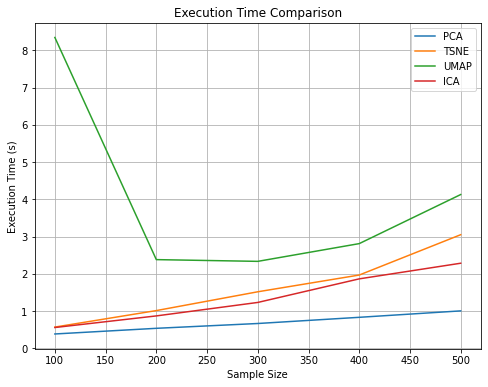

In [8]:
import pandas as pd
import time
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(input_sizes, pca_execution_times, label='PCA')
plt.plot(input_sizes, tsne_execution_times, label='TSNE')
plt.plot(input_sizes, umap_execution_times, label='UMAP')
plt.plot(input_sizes, ica_execution_times, label='ICA')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time Comparison')
plt.legend()
plt.grid(True)
plt.show()